In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

#### Load Anomalies Datasets

In [2]:
# df = pd.read_csv('mid_cap_all_sectors_ret.csv', parse_dates=['date'])
# df.set_index('date', inplace=True)

# train_size = int(len(df) * 0.8)
# train_data = df[:train_size]
# test_data = df[train_size:]
# test_data.to_csv('test_set.csv', index=True)
test_data = pd.read_csv('test_data.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)

In [5]:
anomalies_lstm = pd.read_csv('Anomalies Dataset/lstm.csv', index_col='date', parse_dates=True)
anomalies_cnn = pd.read_csv('Anomalies Dataset/cnn.csv', index_col='date', parse_dates=True)
anomalies_isoforest = pd.read_csv('Anomalies Dataset/isolation_forest.csv', index_col='date', parse_dates=True)
anomalies_knn = pd.read_csv('Anomalies Dataset/knn.csv', index_col='date', parse_dates=True)
anomalies_statistical = pd.read_csv('Anomalies Dataset/statistics.csv', index_col='date', parse_dates=True)
anomalies_mahalanobis = pd.read_csv('Anomalies Dataset/mahalanobis_distance.csv', index_col='date', parse_dates=True)

#### EDA

In [6]:
dates_match = (
    anomalies_lstm.index.equals(anomalies_cnn.index) and
    anomalies_lstm.index.equals(anomalies_knn.index) and
    anomalies_lstm.index.equals(anomalies_isoforest.index) and
    anomalies_lstm.index.equals(anomalies_statistical.index) and
    anomalies_lstm.index.equals(anomalies_mahalanobis.index)
)
print(f"Do all datasets have matching dates? {dates_match}")

columns_match = (
    anomalies_lstm.columns.equals(anomalies_cnn.columns) and
    anomalies_lstm.columns.equals(anomalies_knn.columns) and
    anomalies_lstm.columns.equals(anomalies_isoforest.columns) and
    anomalies_lstm.columns.equals(anomalies_statistical.columns) and
    anomalies_lstm.columns.equals(anomalies_mahalanobis.columns)
)
print(f"Do all datasets have matching sectors? {columns_match}")

Do all datasets have matching dates? True
Do all datasets have matching sectors? True


In [7]:
# combining dataset
anomalies_dict = {
    'LSTM': anomalies_lstm,
    'CNN': anomalies_cnn,
    'KNN': anomalies_knn,
    'IsolationForest': anomalies_isoforest,
    'Statistical': anomalies_statistical,
    'Mahalanobis': anomalies_mahalanobis
}

anomalies_combined = pd.concat(anomalies_dict, axis=1)

In [8]:
sectors = anomalies_lstm.columns
models = list(anomalies_dict.keys())

anomaly_counts = pd.DataFrame(index=sectors, columns=models)

for model in models:
    anomalies = anomalies_dict[model]
    anomaly_counts[model] = anomalies.sum()

print("Anomaly Counts per Sector and Model:")
print(anomaly_counts)

Anomaly Counts per Sector and Model:
                         LSTM  CNN  KNN  IsolationForest  Statistical  \
Materials               121.0   49    9               95           17   
Industrials             128.0   88   12               91           22   
Health Care              55.0  106    6               53           13   
Real Estate              82.0   93   13               73            9   
Consumer Discretionary  144.0  244    9              108            6   
Financials              128.0  111   19              128           24   
Utilities               144.0   85   15              116           28   
Information Technology   39.0   95    8               42            8   
Energy                  208.0  101    5              147           23   
Consumer Staples         52.0   98    1               53           11   
Communication Services   39.0   92    5               43           16   

                        Mahalanobis  
Materials                        14  
Industrial

In [9]:
# Percentage of anomalies over total number of observations
num_observations = anomalies_lstm.shape[0]
anomaly_percentages = (anomaly_counts / num_observations) * 100

print("Percentage of Anomalies per Sector and Model:")
anomaly_percentages

Percentage of Anomalies per Sector and Model:


,LSTM,CNN,KNN,IsolationForest,Statistical,Mahalanobis
Materials,9.750201,3.948429,0.725222,7.655117,1.369863,1.128122
Industrials,10.314263,7.091056,0.966962,7.332796,1.772764,0.966962
Health Care,4.431910,8.541499,0.483481,4.270749,1.047542,0.241741
Real Estate,6.607575,7.493956,1.047542,5.882353,0.725222,0.886382
Consumer Discretionary,11.603546,19.661563,0.725222,8.702659,0.483481,2.739726
Financials,10.314263,8.944400,1.531023,10.314263,1.933924,1.531023
Utilities,11.603546,6.849315,1.208703,9.347301,2.256245,1.208703
Information Technology,3.142627,7.655117,0.644641,3.384367,0.644641,0.644641
Energy,16.760677,8.138598,0.402901,11.845286,1.853344,1.611604
Consumer Staples,4.190169,7.896857,0.080580,4.270749,0.886382,0.564061


In [10]:
# percentage of anomalies across sectors
num_anomaly_by_model = anomaly_counts.sum()
anomaly_percent_sector = anomaly_counts / num_anomaly_by_model

anomaly_percent_sector

,LSTM,CNN,KNN,IsolationForest,Statistical,Mahalanobis
Materials,0.106140,0.042169,0.088235,0.100105,0.096045,0.089744
Industrials,0.112281,0.075731,0.117647,0.095890,0.124294,0.076923
Health Care,0.048246,0.091222,0.058824,0.055848,0.073446,0.019231
Real Estate,0.071930,0.080034,0.127451,0.076923,0.050847,0.070513
Consumer Discretionary,0.126316,0.209983,0.088235,0.113804,0.033898,0.217949
Financials,0.112281,0.095525,0.186275,0.134879,0.135593,0.121795
Utilities,0.126316,0.073150,0.147059,0.122234,0.158192,0.096154
Information Technology,0.034211,0.081756,0.078431,0.044257,0.045198,0.051282
Energy,0.182456,0.086919,0.049020,0.154900,0.129944,0.128205
Consumer Staples,0.045614,0.084337,0.009804,0.055848,0.062147,0.044872


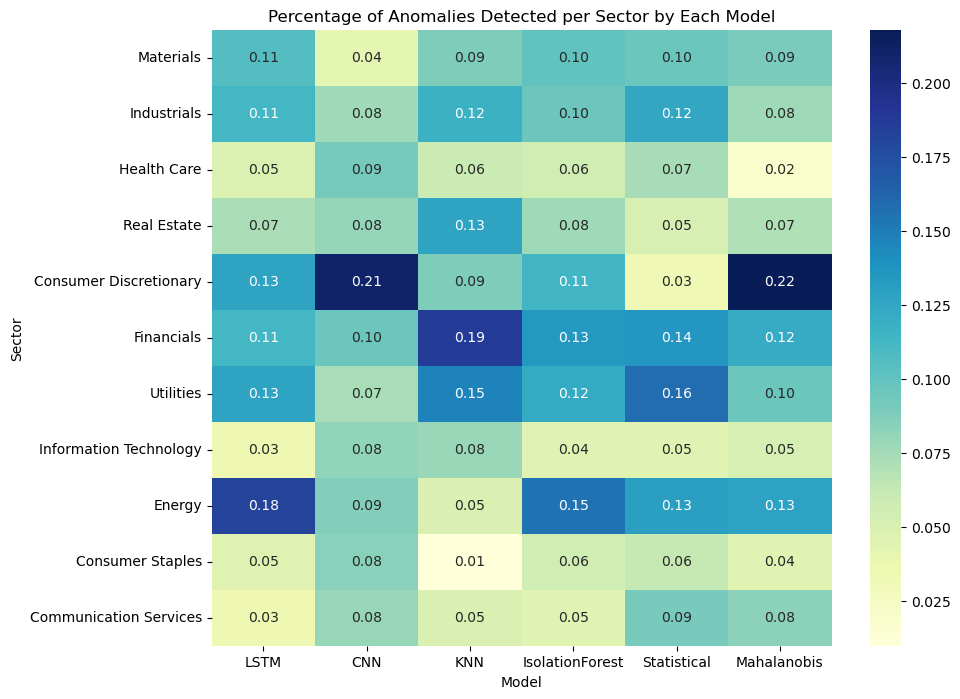

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(anomaly_percent_sector.astype(float), annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Percentage of Anomalies Detected per Sector by Each Model')
plt.xlabel('Model')
plt.ylabel('Sector')
plt.show()

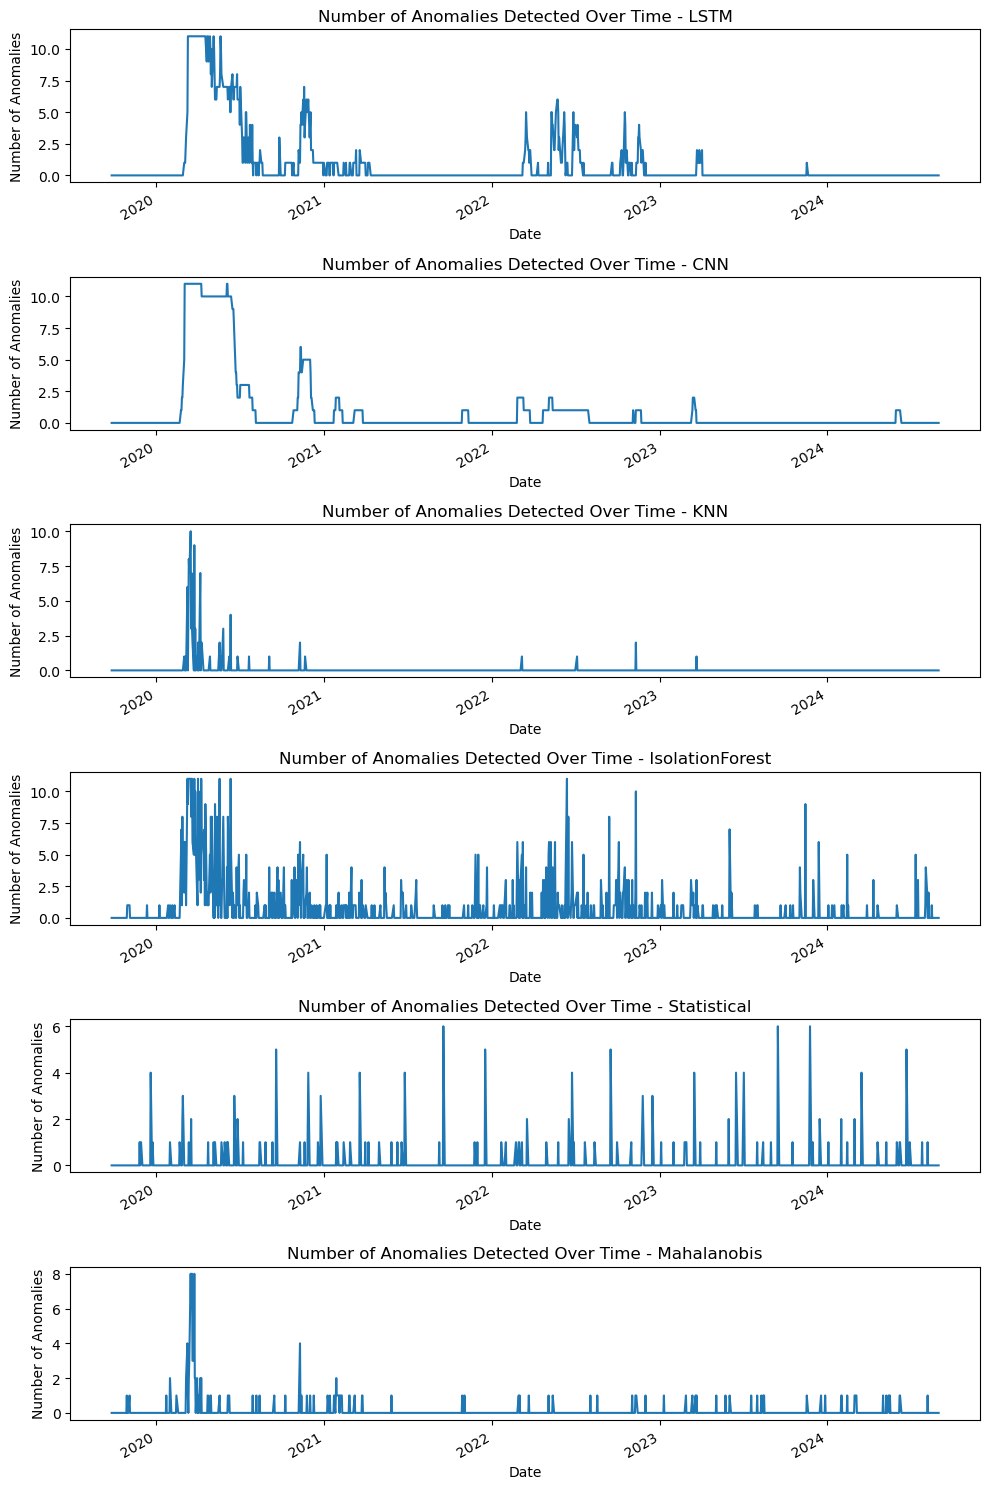

In [12]:
# Distribution of Anomalies
fig, axes = plt.subplots(len(models), 1, figsize=(10, 2.5 * len(models)))

for i, model in enumerate(models):
    anomalies = anomalies_dict[model]
    anomalies_per_date = anomalies.sum(axis=1)
    
    ax = axes[i]
    anomalies_per_date.plot(ax=ax)
    ax.set_title(f'Number of Anomalies Detected Over Time - {model}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Anomalies')

plt.tight_layout()
plt.show()

Jaccard Similarity Index Between Models:


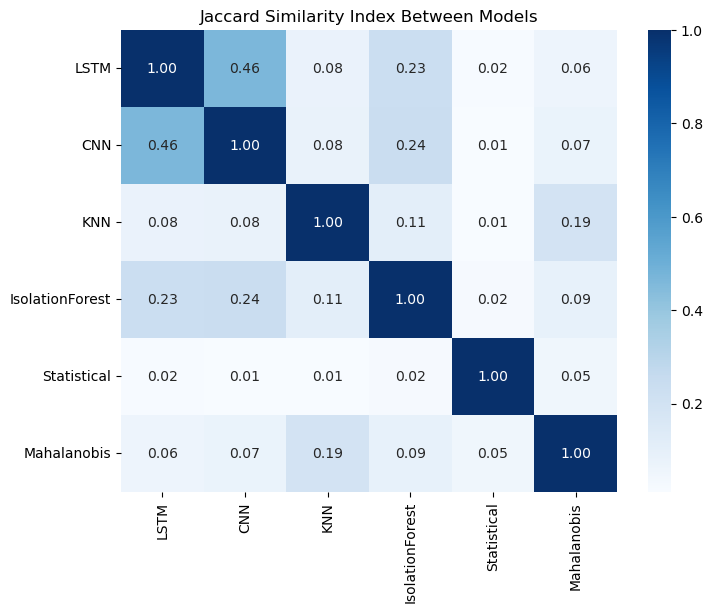

In [13]:
def jaccard_similarity(anomalies1, anomalies2):
    anomalies1_flat = anomalies1.values.flatten()
    anomalies2_flat = anomalies2.values.flatten()
    intersection = np.logical_and(anomalies1_flat == 1, anomalies2_flat == 1).sum()
    union = np.logical_or(anomalies1_flat == 1, anomalies2_flat == 1).sum()
    if union == 0:
        return np.nan
    return intersection / union

jaccard_df = pd.DataFrame(index=models, columns=models)

for model1, model2 in combinations(models, 2):
    sim = jaccard_similarity(anomalies_dict[model1], anomalies_dict[model2])
    jaccard_df.loc[model1, model2] = sim
    jaccard_df.loc[model2, model1] = sim

np.fill_diagonal(jaccard_df.values, 1.0)

print("Jaccard Similarity Index Between Models:")
jaccard_df

plt.figure(figsize=(8, 6))
sns.heatmap(jaccard_df.astype(float), annot=True, cmap='Blues', fmt=".2f")
plt.title('Jaccard Similarity Index Between Models')
plt.show()

Number of consensus anomalies (detected by at least 4 models): 54


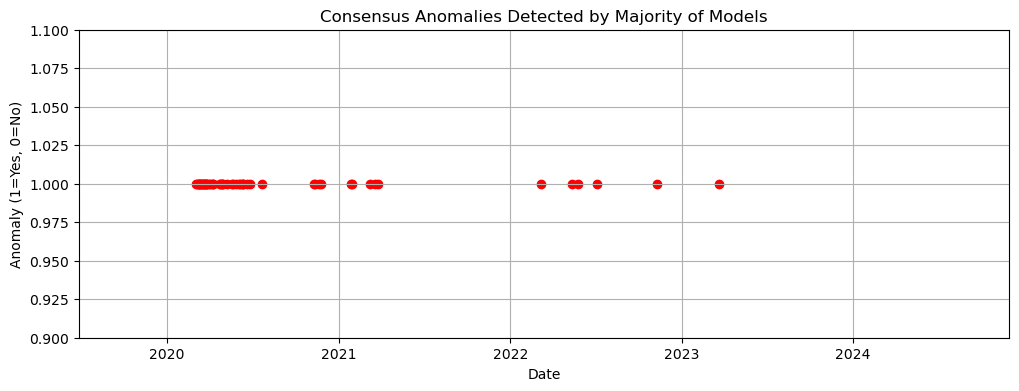

In [14]:
anomalies_flat = pd.DataFrame(index=anomalies_lstm.index)

for model in models:
    # An anomaly is detected if any sector has an anomaly on that date
    anomalies_flat[model] = anomalies_dict[model].any(axis=1).astype(int)

anomalies_sum = anomalies_flat.sum(axis=1)

# Anomalies detected by at least 3 models (majority)
consensus_threshold = len(models) // 2 + 1
consensus_anomalies = anomalies_sum >= consensus_threshold

print(f"Number of consensus anomalies (detected by at least {consensus_threshold} models): {consensus_anomalies.sum()}")

plt.figure(figsize=(12, 4))
plt.scatter(consensus_anomalies.index, consensus_anomalies.astype(int), marker='o', color='red')
plt.title('Consensus Anomalies Detected by Majority of Models')
plt.xlabel('Date')
plt.ylabel('Anomaly (1=Yes, 0=No)')
plt.ylim(0.9, 1.1)
plt.grid(True)
plt.show()

#### Majority Models Consensus Anomaly

In [15]:
sector_anomaly_consensus = {}
consensus_threshold = 3

for sector in anomalies_lstm.columns: 
    anomaly_flat_sector = pd.DataFrame(index = anomalies_lstm.index)

    for model in models:
        anomaly_flat_sector[model] = anomalies_dict[model][sector]

    anomaly_sum_sector = anomaly_flat_sector.sum(axis=1)
    sector_anomaly_consensus[sector] = (anomaly_sum_sector >= consensus_threshold).astype(int)

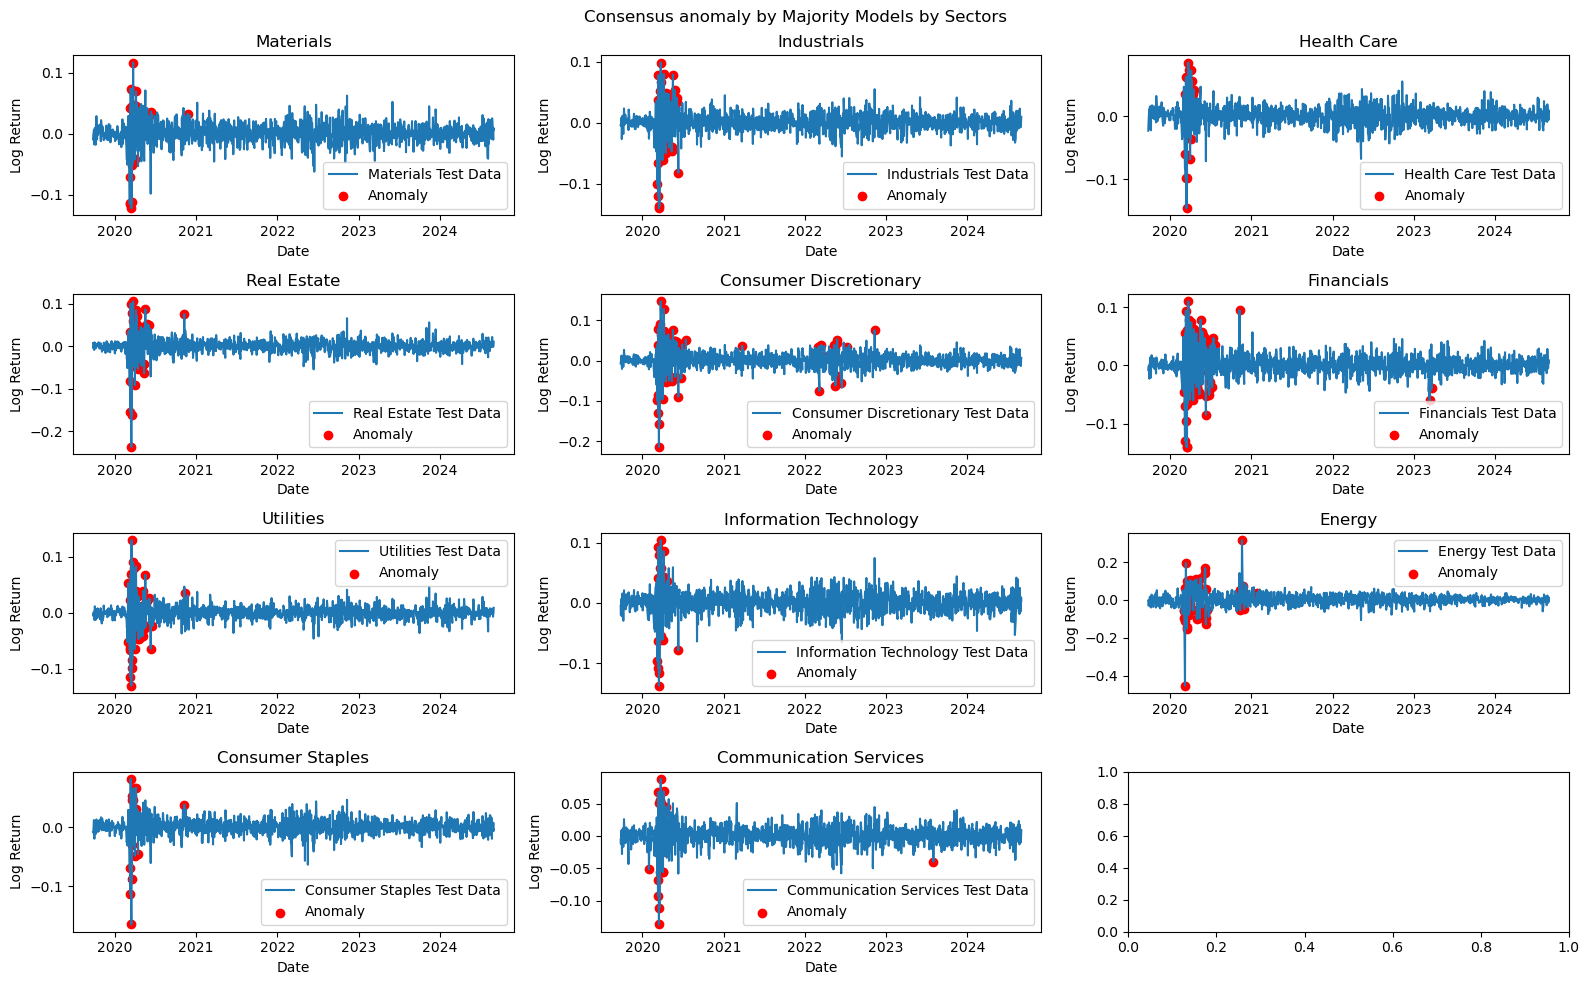

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(16, 10))
fig.suptitle('Consensus anomaly by Majority Models by Sectors')
fig.tight_layout(pad=3.0)

for i, sector in enumerate(anomalies_lstm.columns):
    ax = axes.flatten()[i]

    sector_test = test_data[sector]

    ax.plot(sector_test.index, sector_test.values, label=f'{sector} Test Data')

    consensus_anomaly = sector_anomaly_consensus[sector]
    anomaly_dates = consensus_anomaly[consensus_anomaly == 1].index

    anomaly_values = test_data.loc[anomaly_dates, sector]

    ax.scatter(anomaly_dates, anomaly_values, color='r', marker='o', label='Anomaly')

    ax.set_title(f'{sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.tight_layout()
plt.show()